#### Import Julia packages

In [1]:
# import Pkg
# Pkg.add("JSON3")
# Pkg.add("Interpolations")

In [2]:
using Gridap
using GridapMakie, CairoMakie, FileIO
using Gridap.FESpaces
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Algebra
using Gridap.Geometry
using Gridap.Fields
using Gridap.CellData
using FillArrays
using Test
using InteractiveUtils
using PyPlot
using JSON3
using Dates
# using Interpolations

#### Import Custom functions

In [3]:
include("Julia_functions/indicator_chi.jl")
include("Julia_functions/cost_fun.jl")
include("Julia_functions/gradient_descent.jl")
include("Julia_functions/solvers.jl")
include("Julia_functions/find.jl")
include("Julia_functions/res_plot.jl")
include("Julia_functions/get_domain.jl")
include("Julia_functions/get_price_temp.jl")
include("Julia_functions/post_processing.jl")

get_control_int (generic function with 1 method)

#### Read JSON File

In [4]:
width, height, windows, doors, heating_elem = get_room("Boundary.json")

(5, 3, Any[(0.75125, 2.32125, "Left"), (0.73125, 2.32125, "Right")], Any[(0.235, 0.655, "Top")], [[2.005, 3.435, 0.12125, 0.20125], [1.765, 3.215, 2.80125, 2.89125]])

In [5]:
price_EUR, price_NOK, T_out, hour_lst = get_price_temp("WeatherandEnergy.json")

(Any[0.01669, 0.01319, 0.00967, 0.01037, 0.02006, 0.02314, 0.01764, 0.01828, 0.01869, 0.01863, 0.01817, 0.01777], Any[0.19048, 0.15054, 0.11036, 0.11835, 0.22894, 0.2641, 0.20133, 0.20863, 0.21331, 0.21262, 0.20737, 0.20281], Any[282.15, 282.34999999999997, 282.25, 282.34999999999997, 282.15, 281.45, 280.65, 280.84999999999997, 280.75, 280.45, 280.25, 279.95], Any[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

#### Boundary conditions

In [6]:
f_Γ_w = generate_f_Γ(windows, width, height)
f_Γ_d = generate_f_Γ(doors, width, height)
f_Γ_wall(x) = !(f_Γ_w(x) || f_Γ_d(x))

f_Γ_wall (generic function with 1 method)

#### Domain & Discretization

In [7]:
domain = (0, width , 0, height)
partition = (25,25)
model = CartesianDiscreteModel(domain,partition)
update_labels!(1, model, f_Γ_w, "window")
update_labels!(2, model, f_Γ_d, "door")
update_labels!(3, model, f_Γ_wall, "wall")

order = 1
degree = 2*order

Ω = Triangulation(model)
dΩ = Measure(Ω, degree)

Γ_w = BoundaryTriangulation(model, tags="window")
dΓ_w = Measure(Γ_w, degree)

Γ_d = BoundaryTriangulation(model, tags="door")
dΓ_d = Measure(Γ_d, degree)

Γ_wall = BoundaryTriangulation(model, tags="wall")
dΓ_wall = Measure(Γ_wall, degree)

reffe = ReferenceFE(lagrangian,Float64,order)
Testspace = TestFESpace(model,reffe,conformity=:H1)                         
Trialspace = TransientTrialFESpace(Testspace)                                
Uspace = FESpace(model, reffe, conformity=:H1)

# fig = CairoMakie.plot(Ω)
# scatter!(Ω, marker=:circle, markersize=20, color=:blue) 
# display(fig)

UnconstrainedFESpace()

#### Time parameters

In [8]:
timescale = 1
t0 = 0.0    # Start time
tF = 28800/timescale   # End time
Δt = 10.0   # Timestep

10.0

#### Room parameters

In [9]:
h_wall(x) = 0.22*timescale*0.05           # [W/m^2K]
h_window(x) = 1.2*timescale*0.05
h_door(x) = 1.0*timescale*0.05

ρ(x)=1.225
c(x)=1020.0
k(x)=15.0*timescale 

h = (h_wall, h_window, h_door) 
constants = (c, ρ, k, h) 

#Toutdoor(x,t)=273.0
#Tout(t)=x->Toutdoor(x,t)

Tout = get_temp_function(T_out, tF)

# price = t->1-χ(t,2,8)

Tini(x)=297.0

TIni=interpolate_everywhere(Tini, Uspace(t0))
Tfin=interpolate_everywhere(297.0, Uspace(tF))

SingleFieldFEFunction():
 num_cells: 625
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 9382134005652915751

#### Controll parameter

In [10]:
#q_pos(x) = χ(x[1], 0.21, 1.73) * χ(x[2], 0.13, 0.16)
q_pos = heating_elements(heating_elem)
Q(x,t)=0*q_pos(x)#χ(t,0.0,100.0)*3000.0*q_pos(x)*1.0
Qt(t)=x->Q(x,t)

Qt (generic function with 1 method)

#### Solver parameters

In [11]:
L2norm(u)=√((tF-t0)*∑(Δt*∑(∫(uu⋅uu)*dΩ) for (t,uu) in u))
L2skp(u)=(tF-t0)*∑(Δt*∑(∫(uu⋅uu)*dΩ) for (t,uu) in u)


Proj(a,b,z) = min(max(a,z),b)
a=0.0
b=1000.0*timescale
Proj(z) = [(t,FEFunction(Uspace,map(x->Proj(a,b,x), get_free_dof_values(zz)))) for (t,zz) in z]

Proj (generic function with 2 methods)

#### Test Gradient DEs

In [24]:
price = get_price_function(price_NOK, tF, 1/timescale*0.0)
γ = 5000.0

(Ts,qs,Ws,costs) = GradientDescent(;solveSE=SEsolver, 
solveAE=AEsolver, 
spaces=(Trialspace, Testspace, Uspace), 
dΩ=dΩ, 
dΓ=(dΓ_w,dΓ_d,dΓ_wall), 
Q=Qt, 
J=E, 
∇f=∇e, 
P=Proj, 
s_min=s_min,
sminargs=nothing, 
saveall=false, 
tol=1e-5, 
iter_max=15,
armijoparas=(ρ=0.1, α_0=1, α_min=1e-5, σ=0), 
Δt=Δt, 
t0=t0,
tF=tF,
Tout=Tout,
constants=constants,
Tfin=Tfin,
q_pos=q_pos)

T computed
W computed
entered for loop, E=9.381825406014515e6, k = 1
α = 1, new_cost = 69117.99836739479, L2fgrad = 586127.2971520029, interm = 0.0
entered for loop, E=69117.99836739479, k = 2
α = 1, new_cost = 2533.360774606638, L2fgrad = 50187.29972667513, interm = 0.0
entered for loop, E=2533.360774606638, k = 3
α = 1, new_cost = 350.22380545819505, L2fgrad = 9099.433500641664, interm = 0.0
entered for loop, E=350.22380545819505, k = 4
α = 1, new_cost = 274.62012353349144, L2fgrad = 1628.007939305724, interm = 0.0
entered for loop, E=274.62012353349144, k = 5
α = 1, new_cost = 268.254618199177, L2fgrad = 312.9615867964495, interm = 0.0
entered for loop, E=268.254618199177, k = 6
α = 1, new_cost = 264.1889237769489, L2fgrad = 39.110309288293934, interm = 0.0
entered for loop, E=264.1889237769489, k = 7
α = 1, new_cost = 260.2674896991682, L2fgrad = 25.99460295194358, interm = 0.0
entered for loop, E=260.2674896991682, k = 8
α = 1, new_cost = 256.4120266085007, L2fgrad = 15.1486056089

(Tuple{Float64, SingleFieldFEFunction{GenericCellField{ReferenceDomain}}}[(0.0, SingleFieldFEFunction()), (10.0, SingleFieldFEFunction()), (20.0, SingleFieldFEFunction()), (30.0, SingleFieldFEFunction()), (40.0, SingleFieldFEFunction()), (50.0, SingleFieldFEFunction()), (60.0, SingleFieldFEFunction()), (70.0, SingleFieldFEFunction()), (80.0, SingleFieldFEFunction()), (90.0, SingleFieldFEFunction())  …  (28710.0, SingleFieldFEFunction()), (28720.0, SingleFieldFEFunction()), (28730.0, SingleFieldFEFunction()), (28740.0, SingleFieldFEFunction()), (28750.0, SingleFieldFEFunction()), (28760.0, SingleFieldFEFunction()), (28770.0, SingleFieldFEFunction()), (28780.0, SingleFieldFEFunction()), (28790.0, SingleFieldFEFunction()), (28800.0, SingleFieldFEFunction())], Tuple{Float64, SingleFieldFEFunction{GenericCellField{ReferenceDomain}}}[(0.0, SingleFieldFEFunction()), (10.0, SingleFieldFEFunction()), (20.0, SingleFieldFEFunction()), (30.0, SingleFieldFEFunction()), (40.0, SingleFieldFEFunction(

In [14]:
price = get_price_function(price_NOK, tF, 1/timescale*0.1)
γ = 1e2

(Ts2,qs2,Ws2,costs2) = GradientDescent(;solveSE=SEsolver, 
solveAE=AEsolver, 
spaces=(Trialspace, Testspace, Uspace), 
dΩ=dΩ, 
dΓ=(dΓ_w,dΓ_d,dΓ_wall), 
Q=qs, 
J=E, 
∇f=∇e, 
P=Proj, 
s_min=s_min,
sminargs=nothing, 
saveall=false, 
tol=1e-5, 
iter_max=0,
armijoparas=(ρ=0.1, α_0=1, α_min=1e-7, σ=0.0), 
Δt=Δt, 
t0=t0,
tF=tF,
Tout=Tout,
constants=constants,
Tfin=Tfin,
q_pos=q_pos)

T computed
W computed


(Tuple{Float64, SingleFieldFEFunction{GenericCellField{ReferenceDomain}}}[(0.0, SingleFieldFEFunction()), (10.0, SingleFieldFEFunction()), (20.0, SingleFieldFEFunction()), (30.0, SingleFieldFEFunction()), (40.0, SingleFieldFEFunction()), (50.0, SingleFieldFEFunction()), (60.0, SingleFieldFEFunction()), (70.0, SingleFieldFEFunction()), (80.0, SingleFieldFEFunction()), (90.0, SingleFieldFEFunction())  …  (28710.0, SingleFieldFEFunction()), (28720.0, SingleFieldFEFunction()), (28730.0, SingleFieldFEFunction()), (28740.0, SingleFieldFEFunction()), (28750.0, SingleFieldFEFunction()), (28760.0, SingleFieldFEFunction()), (28770.0, SingleFieldFEFunction()), (28780.0, SingleFieldFEFunction()), (28790.0, SingleFieldFEFunction()), (28800.0, SingleFieldFEFunction())], Tuple{Float64, SingleFieldFEFunction{GenericCellField{ReferenceDomain}}}[(0.0, SingleFieldFEFunction()), (10.0, SingleFieldFEFunction()), (20.0, SingleFieldFEFunction()), (30.0, SingleFieldFEFunction()), (40.0, SingleFieldFEFunction(

In [15]:
real_price = 0
for (t,QQ) in qs2
    real_price+=Δt*price(t)*∑(∫(QQ)*dΩ)
end
temp_difference =  0
tmp = last(Ts2)[2]-Tfin
temp_difference = ∑(∫(tmp)*dΩ)
println(real_price)
println(temp_difference/(width*height))

0.0
-15.817142934881689


In [16]:
# price = get_price_function(price_NOK, tF, 1/timescale*10)
# γ = 1e10

# (Ts3,qs3,Ws3,costs3) = GradientDescent(;solveSE=SEsolver, 
# solveAE=AEsolver, 
# spaces=(Trialspace, Testspace, Uspace), 
# dΩ=dΩ, 
# dΓ=(dΓ_w,dΓ_d,dΓ_wall), 
# Q=qs2, 
# J=E, 
# ∇f=∇e, 
# P=Proj, 
# s_min=s_min,
# sminargs=nothing, 
# saveall=false, 
# tol=1e-5, 
# iter_max=3,
# armijoparas=(ρ=0.1, α_0=0.0001, α_min=1e-7, σ=0.0), 
# Δt=Δt, 
# t0=t0,
# tF=tF,
# Tout=Tout,
# constants=constants,
# Tfin=Tfin,
# q_pos=q_pos)

In [17]:
# # Opprett en mappe for midlertidige filer hvis den ikke eksisterer
# if !isdir("tmp")
#     mkdir("tmp")
# end

# # Initialtilstanden og resten av tidsløsningene
# # uh0 = solution[1][2]  # Første element er (t0, T0), vi henter T0
# # uh  = solution[2:end]  # De resterende løsningene


# uh = Ts
# # Lagre resultater i Paraview-format (VTK)
# createpvd("results") do pvd
#     # Første løsning (t=0)
#     # pvd[0] = createvtk(Ω, "tmp/results_0.vtu", cellfields=["u" => uh0])

#     # Lagrer løsninger for hver tidssteg
#     count = 0
#     for (tn, uhn) in uh
#         if count%5 == 0
#             pvd[tn] = createvtk(Ω, "tmp/results_$tn.vtu", cellfields=["u" => uhn])
#         end
#         count+=1
#     end
# end


In [18]:
# T = get_temperature_int(Ts2, width, height)
# q = get_control_int(qs2)
# result_plot()

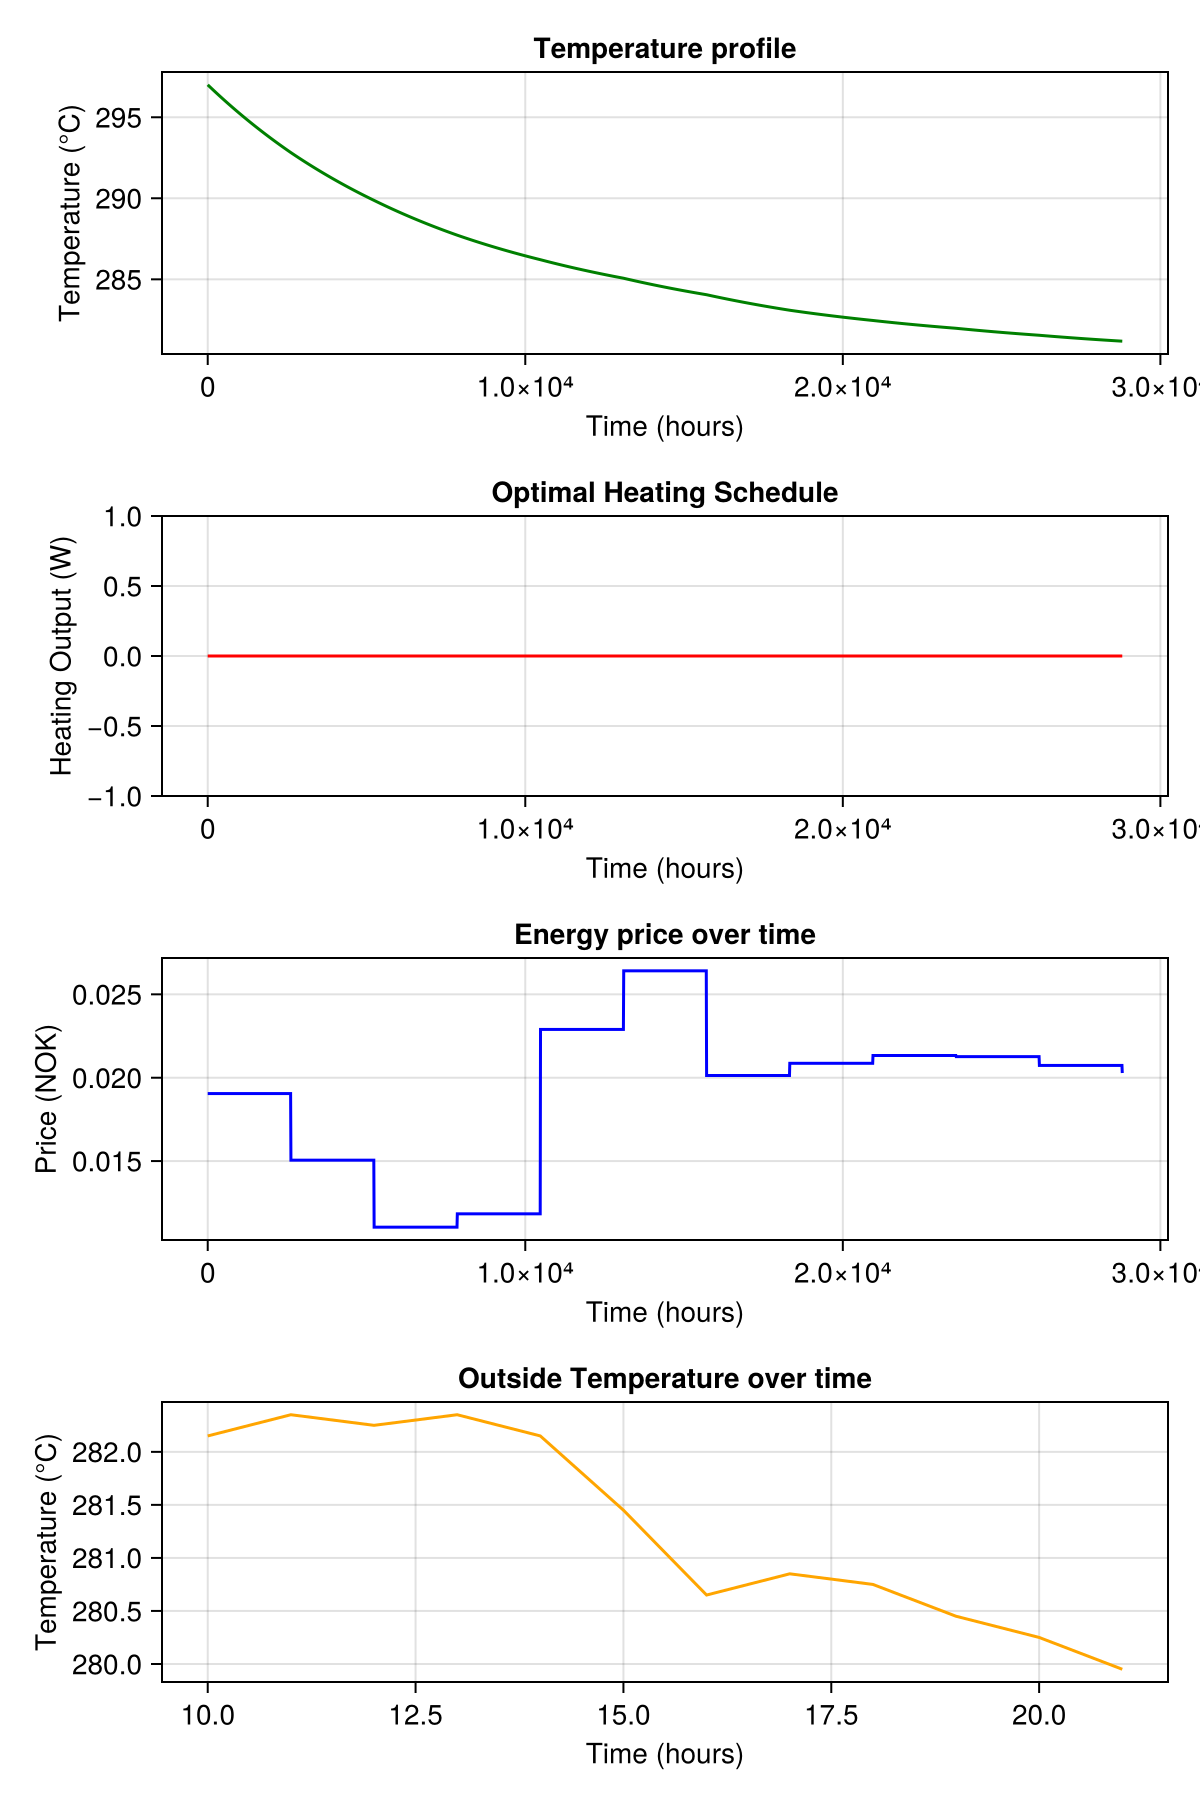

In [19]:
# better version of L2 norm, the scalar product and the functions to get the integrals over Q and T over time

L2norm(u)=√(Δt*((∑(∫(u[1][2]⋅u[1][2])*dΩ)+∑(∫(u[end][2]⋅u[end][2])*dΩ))/2 + ∑(∑(∫(u[k][2]⋅u[k][2])*dΩ) for k=2:length(u)-1)))
L2skp(u)=Δt*((∑(∫(u[1][2]⋅u[1][2])*dΩ)+∑(∫(u[end][2]⋅u[end][2])*dΩ))/2 + ∑(∑(∫(u[k][2]⋅u[k][2])*dΩ) for k=2:length(u)-1))
get_control_int(qs) = [∑(∫(u)*dΩ) for (t,u) in qs]
get_temperature_int(Ts) = [∑(∫(temp)*dΩ) for (t,temp) in Ts] ./ ∑(∫(1)*dΩ)


# Result plot. Now in CairoMakie instead of Pyplot because that is already loaded. I removed the legend on the plots, changed the unit [W] to (W) and I made the function have inputs (just for me, feel free to delete that part)

function result_plot(;T_int, Q_int, t0, tF, hour_lst, price_NOK, T_out)
    time = LinRange(t0, tF, length(T_int))

    fig = CairoMakie.Figure(size=(600,900))

    ax = CairoMakie.Axis(fig[1,1], title="Temperature profile", xlabel="Time (hours)", ylabel="Temperature (°C)")
    lines!(ax, time, T_int, color=:green) #label="Temp"

    ax=CairoMakie.Axis(fig[2,1], title="Optimal Heating Schedule", xlabel="Time (hours)", ylabel="Heating Output (W)")  
    lines!(ax, time, Q_int, color=:red)

    ax=CairoMakie.Axis(fig[3,1], title="Energy price over time", xlabel="Time (hours)", ylabel="Price (NOK)")
    lines!(ax, hour_lst, price_NOK, color=:blue)

    ax=CairoMakie.Axis(fig[4,1], title="Outside Temperature over time", xlabel="Time (hours)", ylabel="Temperature (°C)")
    lines!(ax, hour_lst, T_out, color=:orange)

    return fig
end

# Q_int = get_control_int(qs2)
# T_int = get_temperature_int(Ts2)
# result_plot(;T_int,Q_int,t0,tF,hour_lst,price_NOK,T_out)

function result_plot2(;T_int, Q_int, t0, tF, hour_lst, price_NOK, T_out)
    time = LinRange(t0, tF, length(T_int))
    time_price = []
    for i in 1:length(time)
        push!(time_price,price(time[i]))
    end

    fig = CairoMakie.Figure(size=(600,900))

    ax = CairoMakie.Axis(fig[1,1], title="Temperature profile", xlabel="Time (hours)", ylabel="Temperature (°C)")
    lines!(ax, time, T_int, color=:green) #label="Temp"

    ax=CairoMakie.Axis(fig[2,1], title="Optimal Heating Schedule", xlabel="Time (hours)", ylabel="Heating Output (W)")  
    lines!(ax, time, Q_int, color=:red)

    ax=CairoMakie.Axis(fig[3,1], title="Energy price over time", xlabel="Time (hours)", ylabel="Price (NOK)")
    lines!(ax, time, time_price, color=:blue)

    ax=CairoMakie.Axis(fig[4,1], title="Outside Temperature over time", xlabel="Time (hours)", ylabel="Temperature (°C)")
    lines!(ax, hour_lst, T_out, color=:orange)

    return fig
end

Q_int = get_control_int(qs2)
T_int = get_temperature_int(Ts2)
result_plot2(;T_int,Q_int,t0,tF,hour_lst,price_NOK,T_out)



# In the gradient method right after the first computation of the SE solution (that I call T now instead of y) before the for loop even starts I added a checker whether T_fin can be reached.

# if ∑(∫(last(T)[2]-Tfin)dΩ) < 0
#         println("In the given time the desired final temperature cannot be reached")
#         #return nothing
#     end


# # I added 2 assamblers for the SE and AE solution in order to get better errors when this "nothing-error" occurs. Instead of assambling the T and W inside the solvers I now use that method and who would have guessed: I didn't run into that error since then...

# function assamble_SE_solution(T,t0,Tini,Trialspace)
#     #[(t0,TIni),collect((t,FEFunction(Trialspace(t),copy(get_free_dof_values(TT)))) for (t,TT) in T)...]
#     Tvek=[(t0,Tini)]
#     for (t,TT) in T
#         freedofs=copy(get_free_dof_values(TT))
#         if freedofs==nothing
#             @error("freedofs found for SE are negative for time $t")
#         end
#         push!(Tvek,(t,FEFunction(Trialspace(t),freedofs)))
#     end
#     return Tvek
# end
# function assamble_AE_solution(W,tF,W_end,Trialspace)
#     #[(t0,TIni),collect((t,FEFunction(Trialspace(t),copy(get_free_dof_values(TT)))) for (t,TT) in T)...]
#     Wvek=[(tF,W_end)]
#     for (t,WW) in W
#         freedofs=copy(get_free_dof_values(WW))
#         if freedofs==nothing
#             @error("freedofs found for AE are negative for time $t")
#         end
#         push!(Wvek,(tF-t,FEFunction(Testspace(tF-t),freedofs)))
#     end
#     return reverse!(Wvek)
# end